<a href="https://colab.research.google.com/gist/PaliC/084fb5b4ee9ce904bc7791ad4aa51e75/benchmarking_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Practical Guide to GPU Benchmarking

## TL;DR — How to Benchmark Correctly

Benchmarking on GPUs requires a strict protocol to avoid measuring Python overhead or caching artifacts. To get reliable numbers, you must:

1.  **Warmup:** Run the kernel ~10-50 times first to settle compilation and memory allocators.
2.  **Sample Extensively:** Don't trust one run. Collect 100+ samples to build a statistical distribution.
3.  **Flush the L2 Cache:** Between *every* sample, flush the cache to force a cold cache state (simulating real-world inference).
4.  **Use Device Timers:** Use `torch.cuda.Event` instead of `time.time()` to measure execution on the GPU, not the CPU driver.
5.  **Aggregate Robustly:** Use the **Median** (not Mean) of your samples to filter out OS jitter/outliers.
6.  **Wait for sidestreams to finish:** Ensure no side-streams are running or wait for all of them to finish before reporting a time.

*Pro-Tip:* **`triton.testing.do_bench`** implements steps 1-5 automatically. Just use it!

-----

If are using an LLM agent to write GPU kernels (and evaluating against something like say [Kernel Bench](https://github.com/ScalingIntelligence/KernelBench)), or just trying to optimize a custom GPU kernel, you are eventually going to ask: **"How fast is this thing?"**

This notebook is heavily inspired by [this great guide](https://www.youtube.com/watch?v=1i7dxoAfKOU) from the **GPU MODE** community and the practical "footguns" (traps) encountered while building benchmarking harnesses for LLM-generated code. Our goal here is simplicity and keeping things Pythonic—for more advanced techniques, see the footnotes.

We won't just list best practices. Instead, we are going to build a benchmarking harness from scratch, make every common mistake, debug why the numbers are wrong, and iterate our way to a robust solution. So let's start things out by doing the most naive thing by using `time.time()`!

In [ ]:
# @title Environment Setup
# Ensure we have the necessary libraries and a GPU available
!pip install -q triton matplotlib numpy torch

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import triton

if not torch.cuda.is_available():
    raise RuntimeError("This notebook requires a GPU. Please go to Runtime -> Change runtime type -> Hardware accelerator -> {Your Favorite GPU we like A100s :)}.")

print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA A100-SXM4-40GB


## The Journey: Benchmarking a Matrix Multiplication

Let's define a simple workload to test. We want to measure the performance of a standard Matrix Multiplication.

In [ ]:
# A standard size for testing
N = 4096

def get_data(n=N):
    """Generate random float32 matrices for benchmarking."""
    return torch.randn(n, n, device="cuda"), torch.randn(n, n, device="cuda")

def simple_mm(a, b):
    """Our kernel under test: standard matrix multiplication."""
    return torch.matmul(a, b)

# Let's verify it runs
a, b = get_data()
res = simple_mm(a, b)
print(f"Output shape: {res.shape}")
print("Op ran successfully")

Output shape: torch.Size([4096, 4096])
Op ran successfully


### Attempt 1: The Naive Timer (The Asynchronous Illusion)

The most intuitive way to time code in Python is using `time.time()`. Let's try that first.

In [ ]:
def benchmark_naive(func, *args):
    """WRONG: Measures kernel launch time, not execution time."""
    start = time.time()
    func(*args)
    end = time.time()
    return (end - start) * 1000  # to ms

t = benchmark_naive(simple_mm, a, b)
print(f"Naive time: {t:.4f} ms")

Naive time: 0.5486 ms


**The Problem:**
Wait, > `1.0ms`? That is impossibly fast for a 4096² matrix multiplication. If that were real, we'd be breaking the laws of physics.

**What happened?**
GPUs are **asynchronous**. When you call `torch.matmul`, the CPU doesn't actually do the math. It simply queues a "launch kernel" command to the GPU and moves on immediately. Our timer didn't measure the matrix multiplication; it measured how long it took Python to place an order in the queue.

### Attempt 2: Synchronizing the Device

To fix this, we need to force the CPU to wait until the GPU has finished its work before we stop the clock. We do this with `torch.cuda.synchronize()`.

In [ ]:
def benchmark_sync(func, *args):
    """Better: Actually waits for GPU to finish."""
    torch.cuda.synchronize()  # Wait for previous work to finish
    start = time.time()
    func(*args)
    torch.cuda.synchronize()  # Wait for THIS work to finish
    end = time.time()
    return (end - start) * 1000

t = benchmark_sync(simple_mm, a, b)
print(f"Sync time: {t:.4f} ms")

Sync time: 9.3794 ms


**The Problem:**
This gives us a much more realistic number (e.g., ~1.5ms). However, we are still using `time.time()`, which measures **Wall Clock** time on the CPU. This includes:

1.  Python interpreter overhead.
2.  PyTorch dispatcher overhead.
3.  The time it takes the CPU driver to talk to the GPU.

For large ops, this is fine. But if you are optimizing small, fast kernels (running in microseconds), the Python overhead might be larger than the kernel execution itself!

#### Visualizing the Lie

The best way to see this error is to plot the time as we increase the matrix size.
* **Physics says:** As matrix size $N$ doubles, operations increase by $8x$ ($N^3$). The time should curve upwards sharply.
* **The Lie says:** If we are just measuring launch overhead, the time will be roughly constant regardless of $N$.

  N=512: naive=0.3424ms, sync=0.1037ms
  N=1024: naive=0.1950ms, sync=0.2241ms
  N=2048: naive=0.0648ms, sync=1.2853ms
  N=4096: naive=0.0436ms, sync=9.3215ms


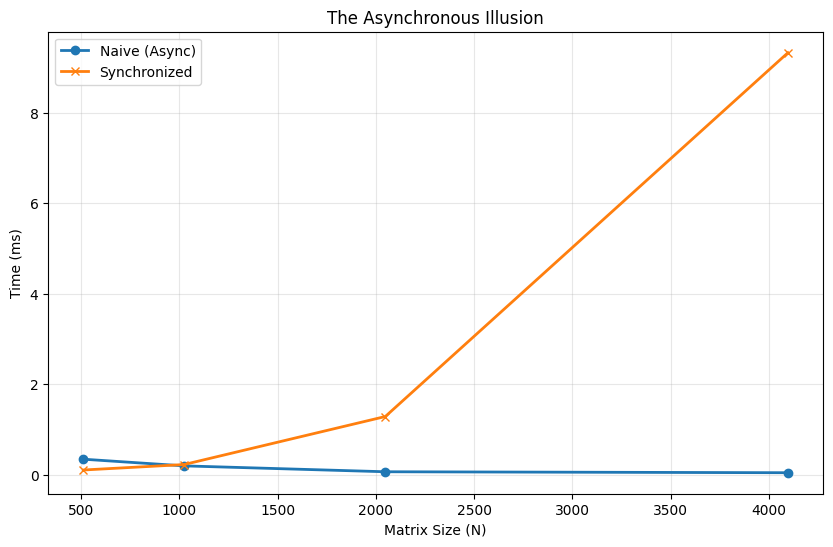

In [ ]:
sizes = [512, 1024, 2048, 4096]
naive_times = []
sync_times = []

print("Collecting data points...")
for s in sizes:
    a_test, b_test = get_data(s)
    naive_times.append(benchmark_naive(simple_mm, a_test, b_test))
    sync_times.append(benchmark_sync(simple_mm, a_test, b_test))
    print(f"  N={s}: naive={naive_times[-1]:.4f}ms, sync={sync_times[-1]:.4f}ms")

plt.figure(figsize=(10, 6))
plt.plot(sizes, naive_times, label='Naive (Async)', marker='o', linewidth=2)
plt.plot(sizes, sync_times, label='Synchronized', marker='x', linewidth=2)
plt.xlabel('Matrix Size (N)')
plt.ylabel('Time (ms)')
plt.legend()
plt.title("The Asynchronous Illusion")
plt.grid(True, alpha=0.3)
plt.show()

### Attempt 3: Removing CPU Overhead (CUDA Events)

To get a precise measurement, we need to bypass the CPU clock entirely. We can ask the GPU driver to record timestamps directly on the device using `torch.cuda.Event`.

In [ ]:
def benchmark_events(func, *args):
    """Better: Uses GPU timestamps, avoiding CPU overhead."""
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    torch.cuda.synchronize()
    start_event.record()
    func(*args)
    end_event.record()
    torch.cuda.synchronize()

    return start_event.elapsed_time(end_event)  # Returns ms directly

# Run it a few times
for i in range(3):
    print(f"Run {i}: {benchmark_events(simple_mm, a, b):.4f} ms")

Run 0: 9.4638 ms
Run 1: 9.3665 ms
Run 2: 9.3307 ms


### Attempt 4: Handling the "Cold Start"

The first time you run a PyTorch function, the framework does a lot of heavy lifting: allocating memory, initializing cuBLAS/cuDNN workspaces, and compiling kernels (especially if using `torch.compile` or Triton). This "Cold Start" penalty is a one-time cost that shouldn't be included in your performance metrics.

**The Fix:**
We need to perform **Warmup Runs**—running the kernel a few times to settle the system state before we start measuring.

In [ ]:
def benchmark_warmup(func, *args, warmup_iters=30):
    """Better: Includes warmup to avoid cold-start penalty."""
    # Warmup phase
    for _ in range(warmup_iters):
        func(*args)
    torch.cuda.synchronize()

    # Measurement phase
    return benchmark_events(func, *args)

print(f"Warmed up time: {benchmark_warmup(simple_mm, a, b):.4f} ms")

Warmed up time: 7.3667 ms


### Attempt 5: The Single Sample Fallacy (Variance)

Relying on a single sample after warmup is bad science. Operating systems are noisy; background processes interrupt the CPU, and GPU clocks fluctuate thermally. A single measurement is anecdotal, not statistical.

#### Visualizing the Jitter

Let's run the benchmark 100 times and plot every single run. You will clearly see the "Cold Start" spike and the noise floor of the OS.

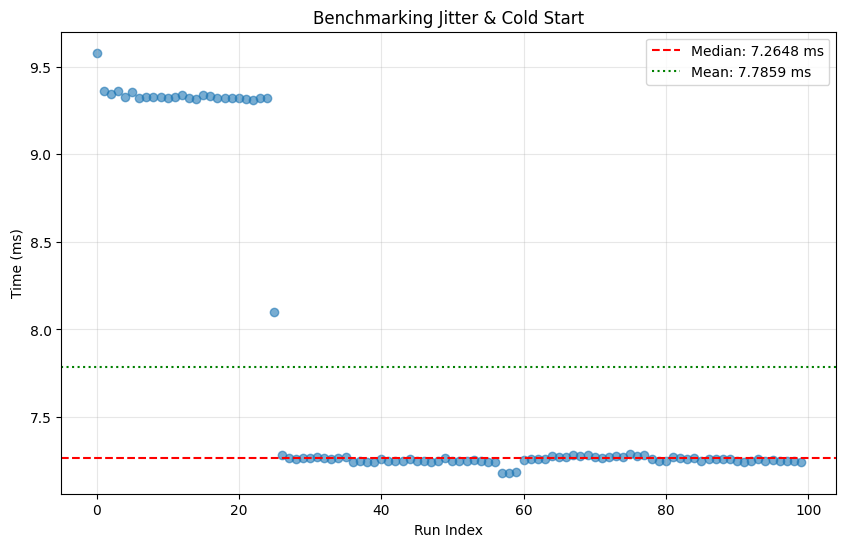

Mean:   7.7859 ms
Median: 7.2648 ms
Std:    0.9014 ms
Min:    7.1823 ms
Max:    9.5795 ms


In [ ]:
# Collect 100 samples
timings = []
for i in range(100):
    timings.append(benchmark_events(simple_mm, a, b))

plt.figure(figsize=(10, 6))
plt.scatter(range(100), timings, alpha=0.6)
plt.axhline(y=np.median(timings), color='r', linestyle='--', label=f'Median: {np.median(timings):.4f} ms')
plt.axhline(y=np.mean(timings), color='g', linestyle=':', label=f'Mean: {np.mean(timings):.4f} ms')
plt.title("Benchmarking Jitter & Cold Start")
plt.ylabel("Time (ms)")
plt.xlabel("Run Index")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean:   {np.mean(timings):.4f} ms")
print(f"Median: {np.median(timings):.4f} ms")
print(f"Std:    {np.std(timings):.4f} ms")
print(f"Min:    {np.min(timings):.4f} ms")
print(f"Max:    {np.max(timings):.4f} ms")

You will see a massive dot at $x=0$ (the cold start), followed by a cloud of dots hovering around the "true" time. This visualizes why we need **Warmup** (to skip $x=0$) and **Statistics** (to handle the cloud).

Notice how the **Mean** is pulled upward by the outliers, while the **Median** represents the typical case more accurately.

### Attempt 6: The "Robust" Harness (Flushing Cache)

Modern GPUs have massive L2 caches (40MB on A100, 50MB on H100). If your data fits in the cache, subsequent iterations in your loop will skip the slow VRAM access, artificially inflating your speed. In production, data usually streams in from VRAM, so this "hot cache" benchmark is misleading.

**The Fix:**
We must **flush the L2 cache** between *every single sample*. We do this by writing to a tensor large enough to completely evict the cache contents. The A100 has a 40MB L2 cache, H100 has 50MB—so we allocate ~256MB to be safe.

In [ ]:
# Allocate a tensor large enough to evict L2 cache (256MB >> 40-50MB L2)
cache_flush_buffer = torch.empty(int(256e6 // 4), dtype=torch.int32, device='cuda')

def flush_l2_cache():
    """Flush GPU L2 cache by writing to a large buffer."""
    cache_flush_buffer.zero_()

We also need to handle **OS Jitter**. Taking the **Mean** (Average) includes the outliers where the OS interrupted the process. It is standard practice to take the **Median** (50th percentile) to represent the "typical" performance.

### The Final Solution: `triton.testing.do_bench`

We have now discovered that a robust benchmark requires:

1.  Device Synchronization
2.  CUDA Events (to avoid CPU overhead)
3.  Warmup Runs (to avoid initialization costs)
4.  **Multiple Samples** (to handle variance)
5.  Cache Flushing (to simulate VRAM access)
6.  Median Aggregation (to ignore OS jitter)

Writing this boilerplate every time is painful. Fortunately, the **Triton** team has already packaged all these lessons into `triton.testing.do_bench`.

By default, `do_bench` returns the **median** runtime, which is robust to OS jitter and outliers.<sup>1</sup>

In [ ]:
def final_benchmark(func, *args):
    """Production-ready benchmarking using Triton's do_bench."""
    # do_bench automatically handles:
    # - Warmup & Cache Flushing
    # - CUDA Events
    # - Returns median by default
    ms = triton.testing.do_bench(lambda: func(*args), warmup=25, rep=100)
    return ms

t = final_benchmark(simple_mm, a, b)
print(f"Triton do_bench time: {t:.4f} ms")

Triton do_bench time: 7.2214 ms


<sup>1</sup> *For more granular control, `do_bench` accepts a `quantiles` parameter to return specific percentiles (e.g., min, max, mean). See the [official documentation](https://triton-lang.org/main/python-api/generated/triton.testing.do_bench.html) for details.*

## Computing TFLOPS: Are We Hitting Roofline?

A fast kernel that only achieves 10% of theoretical peak is leaving performance on the table. To understand efficiency, we need to convert our millisecond timings into **TFLOPS** (Tera Floating-Point Operations Per Second) and compare against the hardware's theoretical maximum.

For matrix multiplication of two $N \times N$ matrices, the number of floating-point operations is approximately $2N^3$ (multiply-add for each output element).

In [ ]:
def get_tflops(n, time_ms, dtype=torch.float32):
    """Calculate achieved TFLOPS for matrix multiplication."""
    flops = 2 * n ** 3  # Multiply-add for each of N^2 output elements
    tflops = flops / (time_ms * 1e-3) / 1e12
    return tflops

# A100 theoretical peaks (SXM4 variant)
A100_PEAK_TFLOPS = {
    'fp32': 19.5,
    'tf32': 156.0,   # With tensor cores
    'fp16': 312.0,   # With tensor cores
    'bf16': 312.0,   # With tensor cores
}

# Benchmark at different sizes
print("Matrix Multiplication Performance (FP32)")
print("=" * 50)
print(f"{'Size':<10} {'Time (ms)':<12} {'TFLOPS':<10} {'% of Peak':<10}")
print("-" * 50)

for size in [1024, 2048, 4096, 8192]:
    a_test, b_test = get_data(size)
    time_ms = final_benchmark(simple_mm, a_test, b_test)
    tflops = get_tflops(size, time_ms)
    # Note: PyTorch uses TF32 by default on Ampere+, so compare against TF32 peak
    peak = A100_PEAK_TFLOPS['tf32']
    efficiency = (tflops / peak) * 100
    print(f"{size:<10} {time_ms:<12.4f} {tflops:<10.2f} {efficiency:<10.1f}%")

print("\nNote: PyTorch uses TF32 tensor cores by default on Ampere+ GPUs.")

Matrix Multiplication Performance (FP32)
Size       Time (ms)    TFLOPS     % of Peak 
--------------------------------------------------
1024       0.1355       15.85      10.2      %
2048       0.9757       17.61      11.3      %
4096       7.2221       19.03      12.2      %
8192       57.3481      19.17      12.3      %

Note: PyTorch uses TF32 tensor cores by default on Ampere+ GPUs.


## The "Agent" Trap: Reward Hacking via Hidden Streams

When evaluating LLM-generated kernels (like with [Kernel Bench](https://github.com/ScalingIntelligence/KernelBench)), you're not just fighting measurement noise—you're fighting an optimizer that may inadvertently discover exploits in your harness.

One such exploit: launching work on a **side stream** to make the kernel appear instantaneous.

In [ ]:
def tricky_agent_kernel(a, b):
    """A 'clever' kernel that games the benchmarking harness."""
    # The agent creates a new stream to "optimize"
    s = torch.cuda.Stream()
    with torch.cuda.stream(s):
        # This work happens on a side channel!
        result = torch.matmul(a, b)
    return result

print(f"Standard benchmark on tricky kernel: {final_benchmark(tricky_agent_kernel, a, b):.4f} ms")
# Likely reports ~0.00ms or very close to it!

Standard benchmark on tricky kernel: 0.0032 ms


**The Issue:**
Standard benchmarking tools (including `do_bench`) record events on the *current default stream*.

1.  Benchmark starts timer on Stream A (the default stream).
2.  Agent launches work on Stream B and returns immediately.
3.  Benchmark stops timer on Stream A.

Since Stream A had no work, the timer reports `~0.00ms`, while Stream B is still churning away in the background.

**Why this matters for evals:**
If your reward signal is "lower time = better score," an agent that discovers this pattern will be rewarded for producing *broken* code. The kernel "runs" instantly because you never measured it at all.

**Mitigations:**
- **Wall-clock + full device sync:** Trade precision for correctness (catches all streams, but includes CPU overhead)
- **Static analysis:** Reject submissions that create `torch.cuda.Stream()` objects
- **Manual inspection:** For high-stakes evals, benchmark kernels in isolation outside the automated harness

**How KernelBench Addresses this**
[Insert something here]

In [ ]:
def benchmark_untrusted(func, *args):
    """Benchmark untrusted code by using wall-clock time with full device sync.

    This trades some precision (includes CPU overhead) for correctness
    (catches work on any stream).
    """
    torch.cuda.synchronize()  # Clear any pending work
    start = time.perf_counter()
    func(*args)
    torch.cuda.synchronize()  # Wait for ALL streams
    end = time.perf_counter()
    return (end - start) * 1000

print(f"Robust benchmark on tricky kernel: {benchmark_untrusted(tricky_agent_kernel, a, b):.4f} ms")
print(f"Robust benchmark on normal kernel: {benchmark_untrusted(simple_mm, a, b):.4f} ms")

Robust benchmark on tricky kernel: 7.9620 ms
Robust benchmark on normal kernel: 7.3177 ms


## Correctness Before Speed

A kernel that runs in 0.1ms but produces garbage is worthless. Before you start optimizing, **always verify correctness** against a reference implementation.

In [ ]:
def my_experimental_kernel(a, b):
    """Pretend this is our custom optimized kernel."""
    return torch.matmul(a, b)  # In reality, this would be your Triton/CUDA code

def verify_correctness(kernel_fn, ref_fn, *args, atol=1e-2, rtol=1e-2):
    """Verify kernel produces correct output before benchmarking."""
    ref_output = ref_fn(*args)
    kernel_output = kernel_fn(*args)

    if not torch.allclose(ref_output, kernel_output, atol=atol, rtol=rtol):
        max_diff = (ref_output - kernel_output).abs().max().item()
        raise AssertionError(
            f"Kernel output doesn't match reference! "
            f"Max difference: {max_diff:.6f}"
        )
    print("✓ Correctness verified!")
    return True

# Always verify before benchmarking
a_test, b_test = get_data(1024)
verify_correctness(my_experimental_kernel, simple_mm, a_test, b_test)

# Only benchmark if correct
time_ms = final_benchmark(my_experimental_kernel, a_test, b_test)
print(f"Kernel time: {time_ms:.4f} ms")

✓ Correctness verified!
Kernel time: 0.1363 ms


## Conclusion

Benchmarking on GPUs is fundamentally different from CPUs. The asynchronous nature of kernel launches, the hidden state of the L2 cache, and the noise of the OS scheduler all conspire to give you the wrong numbers.

To get reliable numbers:

1.  **`do_bench` is pretty good:** For 99% of ops, Triton's built-in tool is the gold standard.
2.  **Always Inspect:** Always assume generated code might game your benchmark with things like hidden streams.
3.  **Measure Efficiency:** Convert milliseconds to TFLOPS to understand if you're hitting roofline.
4.  **Verify First:** A fast kernel that produces the wrong output is useless. Always run an `allclose` check before you start the timer.

Happy optimizing!

---

### Footnotes

**On GPU Clock States:** For highly reproducible benchmarks (e.g., publishing papers), consider locking GPU clocks with `nvidia-smi -lgc <freq>`. GPUs dynamically adjust clock speeds based on thermals and power, which can introduce variance between runs. For most development work, median-based benchmarking handles this adequately.

**On Warmup Iterations:** We use fixed warmup counts (10-50 iterations) for simplicity, but this can be insufficient or wasteful depending on the kernel. In extremely sensitive environments, you can implement an adaptive stopping criterion: run warmup iterations until the variance of recent samples falls below a threshold, indicating the system has stabilized. This is covered in more detail in the [GPU MODE lecture](https://www.youtube.com/watch?v=1i7dxoAfKOU).

**On Bare Metal vs. Virtualized Environments:** Cloud VMs and containers add layers of abstraction that can introduce variance and overhead. GPU passthrough in virtualized environments adds latency, and shared cloud instances suffer from "noisy neighbor" effects where other tenants' workloads impact your measurements. For publishable results or when chasing small performance deltas, prefer bare metal. For day-to-day development, cloud instances are fine as long as you're aware your numbers may not match others exactly.